In [ ]:
!pip install transformers
!pip3 install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import numpy as np
import pandas as pd
import nltk
import torch
import transformers as ppb
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertModel

In [ ]:
WEIGHTS = 'bert-base-uncased'

In [ ]:
def get_labels(df):
    return df['Trendiness']

# Get a trained tokenizer for use with BERT
def get_tokenizer():
    return ppb.DistilBertTokenizer.from_pretrained(WEIGHTS)

# Convert the sentences into lists of tokens
def get_tokens(dataframe, tokenizer):
    return dataframe['Trend Name'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# We want the sentences to all be the same length; pad with 0's to make it so
def pad_tokens(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    return padded

# Grab a trained DistiliBERT model
def get_model():
    return ppb.DistilBertModel.from_pretrained(WEIGHTS)

# This step takes a little while, since it actually runs the model on all sentences.
# Get model with get_model(), 0-padded token lists with pad_tokens() on get_tokens().
# Only returns the [CLS] vectors representing the whole sentence, corresponding to first token.
def get_bert_sentence_vectors(model, padded_tokens):

    # mask = torch.tensor(np.where(padded_tokens != 0, 1, 0))
    # with torch.no_grad():
    #     word_vecs = model(torch.tensor(padded_tokens).to(torch.int64), attention_mask=mask)
    mask = torch.tensor(np.where(padded_tokens != 0, 1, 0))
    with torch.no_grad():
        word_vecs = model(torch.tensor(padded_tokens).to(torch.int64), attention_mask=mask)
    # First vector is for [CLS] token, represents the whole sentence
    cls_vecs = word_vecs[0][:, 0, :].numpy()  # Extract [CLS] vectors and convert to numpy array
    return cls_vecs

In [ ]:
data = pd.read_csv("/content/340 dataset.csv")

In [ ]:
# I am going to commment on these cells that I am testing as extra preprocessing steps with 'PD'
data.dropna(subset=['Trendiness'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
labels = get_labels(data)
tokenizer = get_tokenizer()
tokens = get_tokens(data, tokenizer)

# PD
data['text_length'] = data['Trend Name'].apply(lambda x: len(x.split()))

padded = pad_tokens(tokens)
model = get_model()
vecs = get_bert_sentence_vectors(model, padded)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.
Some weights of DistilBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.word_embeddings.weight', 'transformer.layer.0.attention.k_lin.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.attention.out_lin.weight', 'transformer.layer.0.attention.q_lin.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer

In [ ]:
#PD
item_dummies = pd.get_dummies(data['Item Type'], prefix='Item')
data = pd.concat([data, item_dummies], axis=1)

In [ ]:
print(vecs)

[[ 0.76154685 -0.6952055  -0.7252824  ...  1.5347654   0.98862475
  -0.03319958]
 [ 0.400637   -0.55044436 -0.6154796  ...  2.0339813   1.0595738
   0.07216884]
 [ 0.8513198  -0.83950007 -0.77280664 ...  2.2219334   0.78492457
   0.0600398 ]
 ...
 [ 1.0184697  -0.8240504  -2.1336784  ...  2.33215     0.2616424
  -0.01154958]
 [ 1.2845801  -0.6760592  -0.9336185  ...  1.9987278   0.30165294
  -0.0143997 ]
 [ 0.73184365 -0.5321686  -1.3694588  ...  2.4031181   0.5576417
  -0.11585359]]


In [ ]:
from sklearn.decomposition import PCA

#PD
pca = PCA(n_components=0.95)  # retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
def find_closest_sentences(vecs, sentences):
    best_dist = float("inf")
    best_i = 0
    best_j = 0
    for i, vec1 in enumerate(vecs):
        for j, vec2 in enumerate(vecs):
            if sentences[i] == sentences[j]:
                continue
            dist = np.linalg.norm(vec1-vec2)
            if dist < best_dist:
                best_dist = dist
                best_i = i
                best_j = j
    return sentences[best_i], sentences[best_j]

In [ ]:
find_closest_sentences(vecs, data['Trend Name'])

('Mini Skirts', 'Mini skirts')

Implementing Logistic Regression

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

NaNs in labels: 0
NaNs in BERT vectors: 0


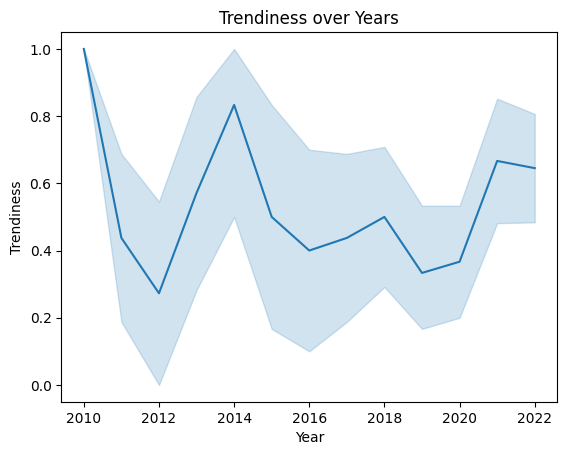

In [ ]:
# Check if there are any NaNs in the labels
print("NaNs in labels:", labels.isna().sum())

# Check if there are any NaNs in the BERT vectors
print("NaNs in BERT vectors:", np.isnan(vecs).sum())

# PD
sns.lineplot(data=data, x='Year', y='Trendiness', estimator=np.mean)
plt.title('Trendiness over Years')
plt.show()

# View rows where labels are NaN
if labels.isna().any():
    print(data[labels.isna()])

In [ ]:
# Drop rows where labels are NaN
if labels.isna().any():
    # Find indices where labels are NaN
    indices_to_drop = labels[labels.isna()].index

    # Drop these indices from labels and features
    labels = labels.drop(indices_to_drop)
    vecs = np.delete(vecs, indices_to_drop, axis=0)

In [ ]:
# New code cell in Google Colab to replace the existing train-test split
X_train, X_test, y_train, y_test = train_test_split(vecs, labels, test_size=0.2, random_state=42, stratify=labels)

# Creating and training the logistic regression model
lr_model = LogisticRegression(max_iter=1000)  # Adjust max_iter if necessary
lr_model.fit(X_train, y_train)

# Evaluate the model
y_pred = lr_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5909090909090909
              precision    recall  f1-score   support

         0.0       0.60      0.55      0.57        22
         1.0       0.58      0.64      0.61        22

    accuracy                           0.59        44
   macro avg       0.59      0.59      0.59        44
weighted avg       0.59      0.59      0.59        44



Implementing SVMs

In [ ]:
from sklearn.svm import SVC  # Support Vector Classifier

In [ ]:
# Create the SVM model with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)

# Fit the model on the training data
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [ ]:
# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

best_svm_linear = grid_search.best_estimator_
y_pred_best_svm_linear = best_svm_linear.predict(X_test_scaled)
print("Linear SVM Accuracy on test set:", accuracy_score(y_test, y_pred_best_svm_linear))
print("Linear SVM Classification report:\n", classification_report(y_test, y_pred_best_svm_linear))

best_svm_rbf = SVC(kernel='rbf', C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])
best_svm_rbf.fit(X_train_scaled, y_train)
y_pred_best_svm_rbf = best_svm_rbf.predict(X_test_scaled)
print("RBF SVM Accuracy on test set:", accuracy_score(y_test, y_pred_best_svm_rbf))
print("RBF SVM Classification report:\n", classification_report(y_test, y_pred_best_svm_rbf))

Linear SVM Accuracy on test set: 0.5909090909090909
Linear SVM Classification report:
               precision    recall  f1-score   support

         0.0       0.59      0.59      0.59        22
         1.0       0.59      0.59      0.59        22

    accuracy                           0.59        44
   macro avg       0.59      0.59      0.59        44
weighted avg       0.59      0.59      0.59        44

RBF SVM Accuracy on test set: 0.5681818181818182
RBF SVM Classification report:
               precision    recall  f1-score   support

         0.0       0.56      0.68      0.61        22
         1.0       0.59      0.45      0.51        22

    accuracy                           0.57        44
   macro avg       0.57      0.57      0.56        44
weighted avg       0.57      0.57      0.56        44



In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],  # Example range for C
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],  # Parameter for kernel coefficient
    'degree': [2, 3, 4]  # Only used with 'poly' kernel
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate on the test set with the best parameters
best_svm = grid_search.best_estimator_
y_pred_best_svm = best_svm.predict(X_test_scaled)
print("Accuracy on test set:", accuracy_score(y_test, y_pred_best_svm))
print("Classification report:\n", classification_report(y_test, y_pred_best_svm))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.6095798319327731
Accuracy on test set: 0.5681818181818182
Classification report:
               precision    recall  f1-score   support

         0.0       0.56      0.68      0.61        22
         1.0       0.59      0.45      0.51        22

    accuracy                           0.57        44
   macro avg       0.57      0.57      0.56        44
weighted avg       0.57      0.57      0.56        44



Identifying Pre-Processing Step

In [ ]:
# Get basic statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())

# Check distribution of labels if 'Trendiness' is your label column
print(data['Trendiness'].value_counts())

              Year  Trendiness  text_length
count   218.000000  218.000000   218.000000
mean   2017.871560    0.495413     1.798165
std       3.528948    0.501130     0.682633
min    2010.000000    0.000000     1.000000
25%    2016.000000    0.000000     1.000000
50%    2019.000000    0.000000     2.000000
75%    2021.000000    1.000000     2.000000
max    2022.000000    1.000000     4.000000
Year                0
Trend Name          0
Item Type           0
Trendiness          0
text_length         0
Item_Accessories    0
Item_Bags           0
Item_Bottoms        0
Item_Colors         0
Item_Dresses        0
Item_Fabric         0
Item_Fit            0
Item_Outerwear      0
Item_Patterns       0
Item_Shoes          0
Item_Style          0
Item_Tops           0
dtype: int64
Trendiness
0.0    110
1.0    108
Name: count, dtype: int64


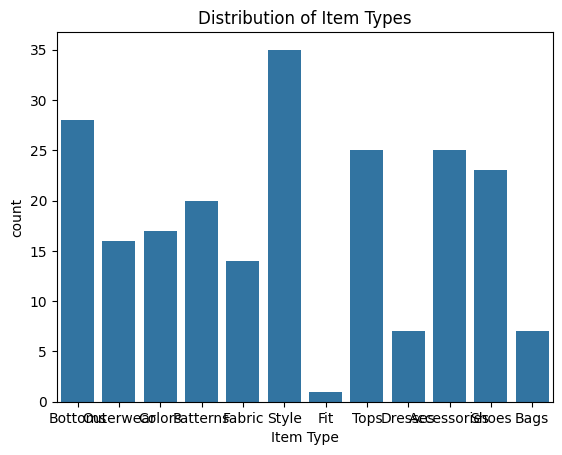

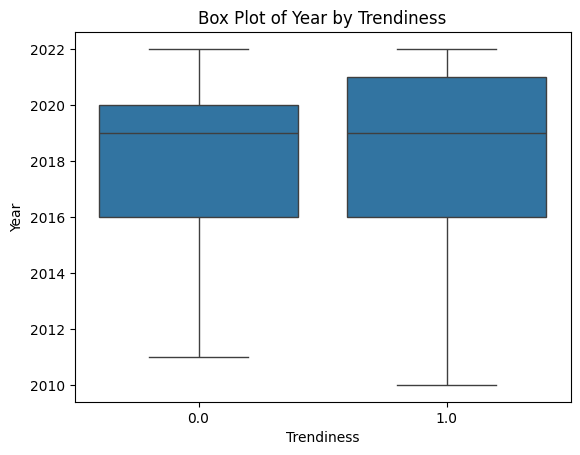

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of categories or a specific feature
sns.countplot(x='Item Type', data=data)
plt.title('Distribution of Item Types')
plt.show()

sns.boxplot(x='Trendiness', y='Year', data=data)
plt.title('Box Plot of Year by Trendiness')
plt.show()


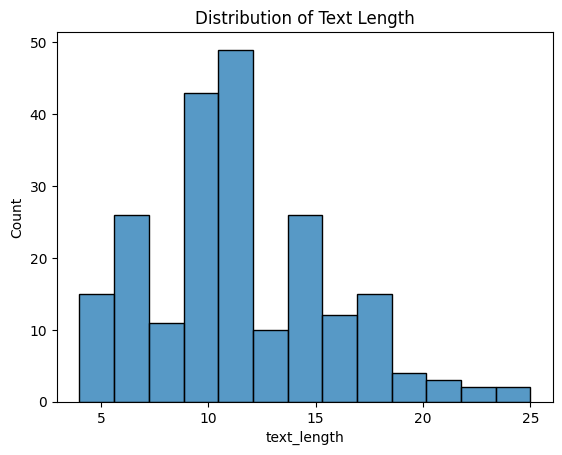

In [ ]:
data['text_length'] = data['Trend Name'].apply(len)
sns.histplot(data['text_length'])
plt.title('Distribution of Text Length')
plt.show()

[our dataset](https://drive.google.com/file/d/1_tXy4uFv95O3D6Rod3-aJbCiqSxE7Mz5/view?usp=sharing)